In [3]:
# Import libraries

import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np

In [4]:
# Import color conversion flags for trying them out on images

flags = [i for i in dir(cv) if i.startswith('COLOR_')]

In [5]:
# Import images

# Gets the file names in the image folder
def get_image_files(folder_path, valid_extensions=("jpg", "jpeg", "png")):
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if
            file.lower().endswith(valid_extensions)]

# Set folder name
folder_path = "images"

# Read image file names and import images
image_files = get_image_files(folder_path)
images = [cv.imread(image_path) for image_path in image_files]

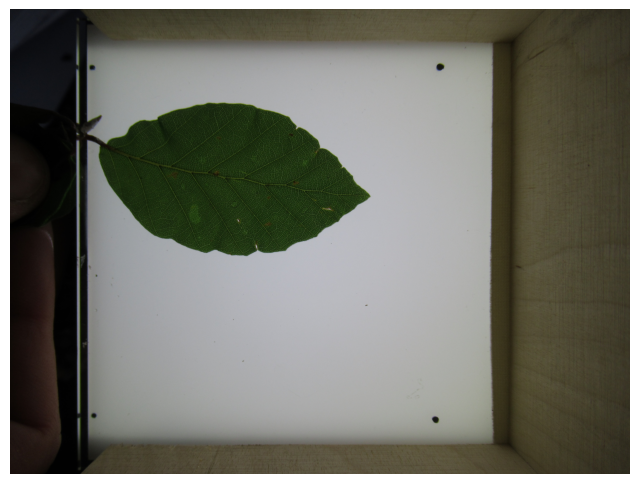

In [ ]:
# Plot a sample image

sample_index = 0
sample_image = images[sample_index]

# Convert the sample image from BGR to RGB format
sample_image_rgb = cv.cvtColor(sample_image, cv.COLOR_BGR2RGB)

# Plot the sample image
plt.figure(figsize=(8, 8))
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Compute HSV green
green = np.uint8([[[0,255,0]]])
hsv_green = cv.cvtColor(green,cv.COLOR_BGR2HSV)
print(hsv_green)

In [ ]:
# load image
image = sample_image

plt.rcParams['figure.dpi'] = 500

# convert to HSV
hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# define range of green color in HSV
lower_green = np.array([0, 100, 100])
upper_green = np.array([255, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv.inRange(hsv, lower_green, upper_green)

# invert the mask to get non-green parts
mask_inv = cv.bitwise_not(mask)

# Bitwise-AND mask and original image
res = cv.bitwise_and(image, image, mask=mask_inv)

plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.title('Result')
plt.axis('off')

plt.show()